# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']
train['rougher_calculation.recovery'] = ((c*(f-t))/(f*(c-t)))*100


In [7]:

mae_recovery = (train['rougher_calculation.recovery']-train['rougher.output.recovery']).abs().mean()
print(mae_recovery)


9.444891926100695e-15


MAE очень мала - следовательно данные по обогащению и расчетные данные совпадают.

In [8]:
column_comparison = pd.DataFrame(train.columns)
column_comparison['test'] = pd.DataFrame(test.columns)
column_comparison.columns = ['train', 'test']
column_comparison = column_comparison.apply(set)
dif = column_comparison['train']-column_comparison['test']
print(dif)

{'primary_cleaner.output.concentrate_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'secondary_cleaner.output.tail_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_ag', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher_calculation.recovery', 'final.output.tail_au', 'primary_cleaner.output.concentrate_sol', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.output.concentrate_pb', 'final.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.calculation.au_pb_ratio', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'final.output.recovery', 'final.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tail_pb', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_sol', 'secondary_cleaner.output.tail_ag', 'rougher.output.tail_au', 'final.output.concentrate_au', 'rougher.output.

В тестовой выборке нет столбцов с результатами обогащения. Тип данных "float", количественные.

В данных есть пропуски. Для целевых столбцов удалим данные, для остальных заменим их на предыдущее значение.

In [9]:
for column in ['rougher.output.recovery', 'final.output.recovery']:
    print("количество пропусков в выборке train "+str(column), train[column].isna().sum())
    print("количество пропусков в выборке gold_recovery_full "+str(column), gold_recovery_full[column].isna().sum())


количество пропусков в выборке train rougher.output.recovery 2573
количество пропусков в выборке gold_recovery_full rougher.output.recovery 3119
количество пропусков в выборке train final.output.recovery 1521
количество пропусков в выборке gold_recovery_full final.output.recovery 1963


In [10]:
train = train.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)
gold_recovery_full = gold_recovery_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)

Остальные пропуски заменим на предыдущее значение

In [11]:
train = train.fillna(method='ffill')
#print(gold_recovery_full.info())
test = test.fillna(method='ffill')
gold_recovery_full = gold_recovery_full.fillna(method='ffill')

# 2. Анализ данных

In [12]:
data = {}
stat = pd.DataFrame(data) 
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
              'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
              'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag',
              'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']: 
    stat[column] = train[column].describe()
display(stat)

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,8.579195,3.505465,36.290933,7.866577,11.775812,7.664555,28.292820,19.439958,8.200916,9.568544,10.016250,32.386836,5.141921,10.132848,9.109311,44.003792
std,1.896284,1.090064,4.977652,1.919506,2.731747,1.856279,6.119659,3.765192,2.005185,2.709330,4.110548,5.798843,1.369603,1.654925,2.886929,4.905261
min,0.010000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.132802,2.766515,34.086892,6.596217,10.486871,6.850501,26.696213,18.432161,7.107126,8.315997,7.376454,30.857764,4.211500,9.296833,7.422466,43.276111
50%,8.156092,3.414267,37.008684,7.649138,11.747362,7.760435,29.254966,19.947312,8.226247,9.920598,9.648025,33.225835,4.994607,10.297013,8.801909,44.872436
75%,9.918304,4.220115,39.410720,9.066976,13.426419,8.601927,31.743943,21.392714,9.504924,11.298487,12.974629,35.330145,5.859495,11.170578,10.452148,46.166425
max,14.596026,7.142594,48.363177,13.126043,24.480271,13.617072,38.351193,28.146838,16.081632,17.081278,22.280845,45.933934,16.001945,17.031899,18.124851,52.756638


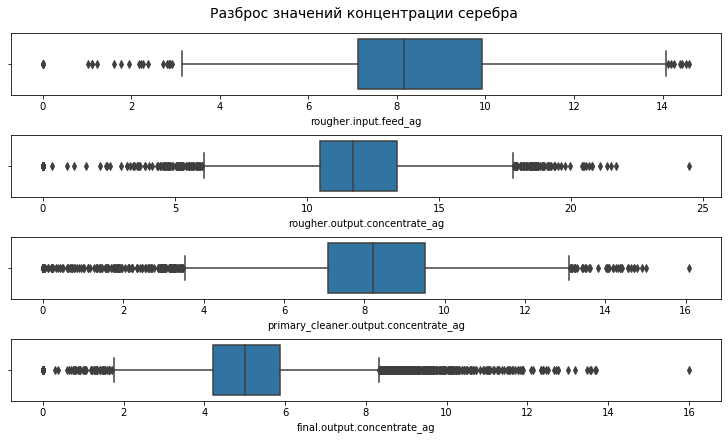

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Разброс значений концентрации серебра', fontsize=14)
ax1 = sns.boxplot(y='rougher.input.feed_ag', data=train, ax=ax1, orient='h')
ax2 = sns.boxplot(y='rougher.output.concentrate_ag', ax=ax2, data=train, orient='h')
ax3 = sns.boxplot(y='primary_cleaner.output.concentrate_ag', ax=ax3, data=train, orient='h')
ax4 = sns.boxplot(y='final.output.concentrate_ag', data=train, ax=ax4, orient='h')

plt.show()

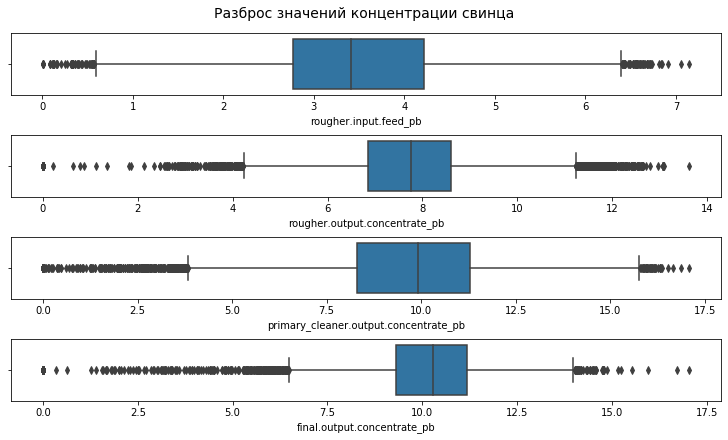

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Разброс значений концентрации свинца', fontsize=14)
ax1 = sns.boxplot(y='rougher.input.feed_pb', data=train, ax=ax1, orient='h')
ax2 = sns.boxplot(y='rougher.output.concentrate_pb', ax=ax2, data=train, orient='h')
ax3 = sns.boxplot(y='primary_cleaner.output.concentrate_pb', ax=ax3, data=train, orient='h')
ax4 = sns.boxplot(y='final.output.concentrate_pb', data=train, ax=ax4, orient='h')

plt.show()

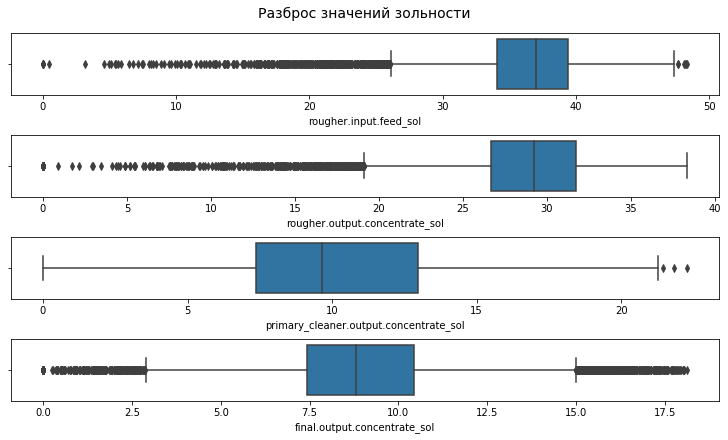

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Разброс значений зольности', fontsize=14)
ax1 = sns.boxplot(y='rougher.input.feed_sol', data=train, ax=ax1, orient='h')
ax2 = sns.boxplot(y='rougher.output.concentrate_sol', ax=ax2, data=train, orient='h')
ax3 = sns.boxplot(y='primary_cleaner.output.concentrate_sol', ax=ax3, data=train, orient='h')
ax4 = sns.boxplot(y='final.output.concentrate_sol', data=train, ax=ax4, orient='h')

plt.show()

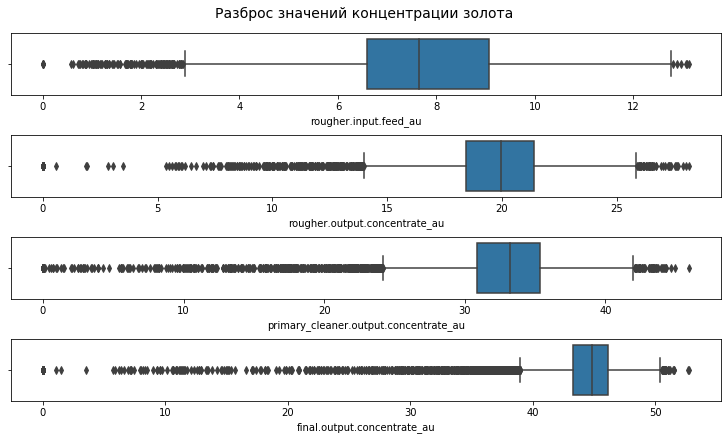

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Разброс значений концентрации золота', fontsize=14)
ax1 = sns.boxplot(y='rougher.input.feed_au', data=train, ax=ax1, orient='h')
ax2 = sns.boxplot(y='rougher.output.concentrate_au', ax=ax2, data=train, orient='h')
ax3 = sns.boxplot(y='primary_cleaner.output.concentrate_au', ax=ax3, data=train, orient='h')
ax4 = sns.boxplot(y='final.output.concentrate_au', data=train, ax=ax4, orient='h')

plt.show()

С каждым этапом обогащения границы разброса значений концентрации золота и свинца возрастают, так же увеличиваются и средние значения. Следовательно обогащение происходит эффективно. Однако концентрация серебра и зольности уменьщаются с каждым этапом обогащения.

In [17]:
train['rougher.input.concentate'] = (train['rougher.input.feed_ag']+train['rougher.input.feed_pb']
                                     +train['rougher.input.feed_sol']+train['rougher.input.feed_au'])
train['rougher.output.concentate'] = (train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb']
                                     +train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au'])
train['primary_cleaner.output.concentate'] = (train['primary_cleaner.output.concentrate_ag']+train['primary_cleaner.output.concentrate_pb']
                                     +train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au'])
train['final.output.concentate'] = (train['final.output.concentrate_ag']+train['final.output.concentrate_pb']
                                     +train['final.output.concentrate_sol']+train['final.output.concentrate_au'])


In [18]:
concentrate = pd.DataFrame(train['rougher.input.concentate'])
concentrate['rougher.output.concentate'] = train['rougher.output.concentate']
concentrate['diff_rougher'] = concentrate['rougher.output.concentate']/train['rougher.input.concentate']*100

concentrate['primary_cleaner.output.concentate'] = train['primary_cleaner.output.concentate']
concentrate['diff_primary_cleaner'] = concentrate['primary_cleaner.output.concentate']/train['rougher.output.concentate']*100

concentrate['final.output.concentate'] = train['final.output.concentate']
concentrate['diff_final'] = concentrate['final.output.concentate']/train['primary_cleaner.output.concentate']*100

concentrate.columns = ['rougher_input_concentate', 'rougher_output_concentate', 'diff_rougher', 
                       'primary_cleaner_output_concentate', 'diff_primary_cleaner', 'final_output_concentate', 'diff_final']

In [19]:
display(concentrate.query('diff_rougher<=0'))

,rougher_input_concentate,rougher_output_concentate,diff_rougher,primary_cleaner_output_concentate,diff_primary_cleaner,final_output_concentate,diff_final
45,58.602038,0.0,0.0,74.992510,inf,66.175996,88.243473
46,59.921613,0.0,0.0,75.187102,inf,66.794250,88.837379
47,57.269041,0.0,0.0,75.513787,inf,67.572604,89.483797
48,25.352358,0.0,0.0,75.491415,inf,65.598903,86.895844
49,40.721375,0.0,0.0,71.837866,inf,63.445359,88.317433
...,...,...,...,...,...,...,...
10330,58.106496,0.0,0.0,68.284696,inf,70.703344,103.542006
10331,59.500740,0.0,0.0,68.539751,inf,70.814703,103.319171
10332,60.129638,0.0,0.0,69.365785,inf,71.329178,102.830492
10333,59.267147,0.0,0.0,69.325494,inf,71.195925,102.698042


Есть аномальные значения равные 0 в суммарных концентрациях, хотя на следующих этапах очистки есть значения отличные от нуля. Вероятно связано с ощибками в измерении - удалим эти значения, а также околонулевые.

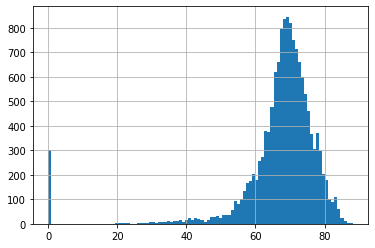

In [20]:
concentrate['rougher_output_concentate'].hist(bins=100)

,rougher.input.concentate,rougher.output.concentate,primary_cleaner.output.concentate,final.output.concentate
count,14149.000000,14149.000000,14149.000000,14149.000000
mean,56.242170,67.173145,60.172546,68.387872
std,7.029808,12.713129,10.448165,7.023723
min,0.040000,0.000000,0.000000,0.000000
25%,52.573579,64.914390,58.046816,67.559819
50%,56.627635,69.175663,61.786946,69.141502
75%,60.763234,73.429261,65.355951,70.974661
max,74.458253,88.140119,76.918076,80.210644


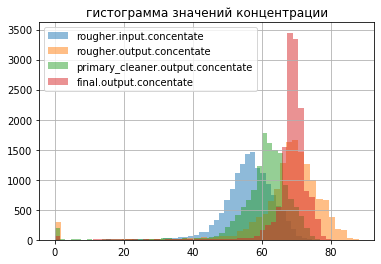

In [21]:
data = {}
stat = pd.DataFrame(data)
for column in ['rougher.input.concentate',
              'rougher.output.concentate', 'primary_cleaner.output.concentate', 'final.output.concentate']:  
    train[column].hist(bins=50, label=column, alpha = 0.5)
    plt.legend(prop={'size': 10})
    plt.title('гистограмма значений концентрации')
    stat[column] = train[column].describe()
display(stat)

Избавимся от аномальных значений концентраций.

In [22]:
#создадим функцию для удаления выбросов
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    #fence_high = q3+1.5*iqr
    df_out = df_in.loc[df_in[col_name] > fence_low]
    return df_out[col_name]


In [23]:
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
               'final.output.concentrate_sol', 'final.output.concentrate_au']:
    train[column] = remove_outlier(train, column)
    

In [24]:
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                             'rougher.input.feed_au']:
    test[column] = remove_outlier(test, column)

In [25]:
train = train.dropna(subset=['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
               'final.output.concentrate_sol', 'final.output.concentrate_au']).reset_index(drop=True)
test = test.dropna(subset=['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                             'rougher.input.feed_au']).reset_index(drop=True)

In [26]:
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
               'final.output.concentrate_sol', 'final.output.concentrate_au']:
    gold_recovery_full[column] = remove_outlier(gold_recovery_full, column)

In [27]:
gold_recovery_full = gold_recovery_full.dropna(subset=['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
               'final.output.concentrate_sol', 'final.output.concentrate_au']).reset_index(drop=True)

In [28]:
#Проверим как сработало
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au',
               'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
               'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
               'final.output.concentrate_sol', 'final.output.concentrate_au']:
    print("количество пропусков в выборке train "+str(column), train[column].isna().sum())
    
    

количество пропусков в выборке train rougher.input.feed_ag 0
количество пропусков в выборке train rougher.input.feed_pb 0
количество пропусков в выборке train rougher.input.feed_sol 0
количество пропусков в выборке train rougher.input.feed_au 0
количество пропусков в выборке train rougher.output.concentrate_ag 0
количество пропусков в выборке train rougher.output.concentrate_pb 0
количество пропусков в выборке train rougher.output.concentrate_sol 0
количество пропусков в выборке train rougher.output.concentrate_au 0
количество пропусков в выборке train primary_cleaner.output.concentrate_ag 0
количество пропусков в выборке train primary_cleaner.output.concentrate_pb 0
количество пропусков в выборке train primary_cleaner.output.concentrate_sol 0
количество пропусков в выборке train primary_cleaner.output.concentrate_au 0
количество пропусков в выборке train final.output.concentrate_ag 0
количество пропусков в выборке train final.output.concentrate_pb 0
количество пропусков в выборке trai

In [29]:
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol',
                             'rougher.input.feed_au']:
    print("количество пропусков в выборке test "+str(column), test[column].isna().sum())

количество пропусков в выборке test rougher.input.feed_ag 0
количество пропусков в выборке test rougher.input.feed_pb 0
количество пропусков в выборке test rougher.input.feed_sol 0
количество пропусков в выборке test rougher.input.feed_au 0


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
count,11404.000000,11404.000000,11404.000000,11404.000000
mean,8.619732,3.605218,37.067002,8.008853
std,1.837761,1.011415,3.750690,1.796251
min,3.871944,0.592658,26.140048,2.891693
25%,7.152128,2.882960,34.643624,6.735540
50%,8.214235,3.498013,37.308752,7.783239
75%,9.965022,4.272967,39.637730,9.160972
max,14.533698,7.142594,48.195295,13.126043


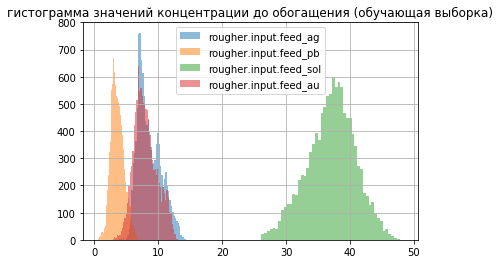

In [30]:
data = {}
stat = pd.DataFrame(data)
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']:  
    train[column].hist(bins=50, label=column, alpha = 0.5)
    plt.legend(prop={'size': 10})
    plt.title('гистограмма значений концентрации до обогащения (обучающая выборка)')
    stat[column] = train[column].describe()
display(stat)


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_au
count,5333.000000,5333.000000,5333.000000,5333.000000
mean,9.425823,3.844326,37.843386,9.399986
std,1.891820,0.925364,5.126461,1.556312
min,3.344375,1.334322,21.045600,4.113296
25%,8.169052,3.271224,34.486719,8.294891
50%,9.797448,3.758706,38.010753,9.624340
75%,10.674223,4.314617,41.644258,10.479923
max,14.406130,6.905684,53.477742,13.731330


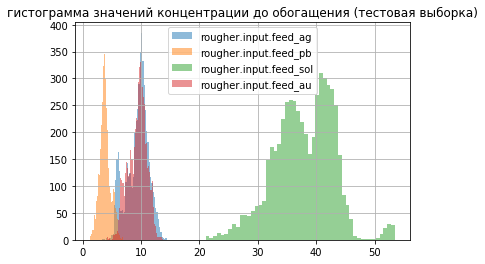

In [31]:
data = {}
stat = pd.DataFrame(data)
for column in ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']:  
    test[column].hist(bins=50, label=column, alpha = 0.5)
    plt.legend(prop={'size': 10})
    plt.title('гистограмма значений концентрации до обогащения (тестовая выборка)')
    stat[column] = test[column].describe()
display(stat)

In [32]:
train['rougher.input.concentate'] = (train['rougher.input.feed_ag']+train['rougher.input.feed_pb']
                                     +train['rougher.input.feed_sol']+train['rougher.input.feed_au'])
train['rougher.output.concentate'] = (train['rougher.output.concentrate_ag']+train['rougher.output.concentrate_pb']
                                     +train['rougher.output.concentrate_sol']+train['rougher.output.concentrate_au'])
train['primary_cleaner.output.concentate'] = (train['primary_cleaner.output.concentrate_ag']+train['primary_cleaner.output.concentrate_pb']
                                     +train['primary_cleaner.output.concentrate_sol']+train['primary_cleaner.output.concentrate_au'])
train['final.output.concentate'] = (train['final.output.concentrate_ag']+train['final.output.concentrate_pb']
                                     +train['final.output.concentrate_sol']+train['final.output.concentrate_au'])

,rougher.input.concentate,rougher.output.concentate,primary_cleaner.output.concentate,final.output.concentate
count,11404.000000,11404.000000,11404.000000,11404.000000
mean,57.300805,69.859167,62.088851,69.669460
std,5.521697,5.973628,5.242442,2.684247
min,38.455788,46.721528,38.918013,56.762608
25%,53.559311,66.162121,59.042651,67.965613
50%,57.111040,69.747726,62.186844,69.386267
75%,61.087850,73.725027,65.483888,71.165207
max,74.458253,86.994951,76.918076,80.210644


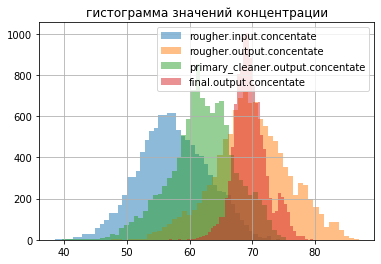

In [33]:
data = {}
stat = pd.DataFrame(data)
for column in ['rougher.input.concentate',
              'rougher.output.concentate', 'primary_cleaner.output.concentate', 'final.output.concentate']:  
    train[column].hist(bins=50, label=column, alpha = 0.5)
    plt.legend(prop={'size': 10})
    plt.title('гистограмма значений концентрации')
    stat[column] = train[column].describe()
display(stat)

Аномальные значения удалены.

'обучающая выборка'

count    11404.000000
mean        60.351981
std         21.990163
min          9.659576
25%         49.337701
50%         55.391451
75%         66.215169
max        484.967466
Name: rougher.input.feed_size, dtype: float64

'тестовая выборка'

count    5333.000000
mean       56.144555
std        20.098964
min         0.046369
25%        43.893336
50%        51.175802
75%        62.511437
max       477.445473
Name: rougher.input.feed_size, dtype: float64

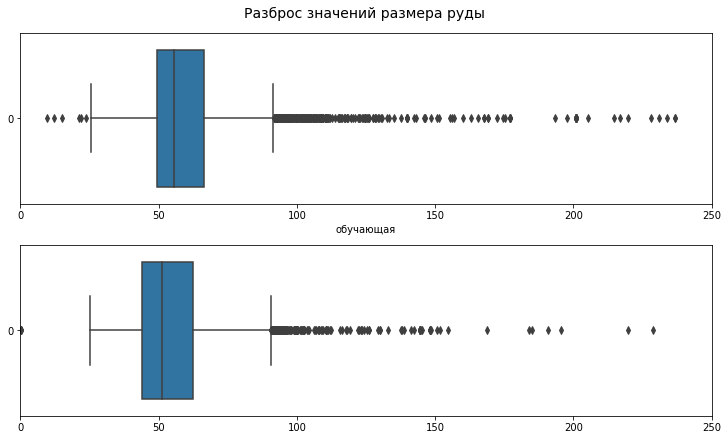

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6), constrained_layout=True)
fig.suptitle('Разброс значений размера руды', fontsize=14)
sns.boxplot(data=train['rougher.input.feed_size'], ax=ax1, orient='h')
ax1.set_xlim([0, 250])
ax1.set_xlabel('обучающая')
sns.boxplot(data=test['rougher.input.feed_size'], ax=ax2, orient='h')
plt.xlim(0, 250)
plt.show
display('обучающая выборка', train['rougher.input.feed_size'].describe())
display('тестовая выборка', test['rougher.input.feed_size'].describe())

Размеры гранул сырья примерно равны в обеих выборках, небольшие различия возможны из-за выбросов.

# 3. Модель

In [35]:
#Функция расчета метрики sMAPE
def sMAPE(y_true, y_pred):
    
    numerator = np.abs(y_true-y_pred)
    denominator =(np.abs(y_true)+np.abs(y_pred))/2
    
    output = np.divide(numerator, denominator)
    
    output_scores = np.average(output, axis=0)
    
    return np.average(output_scores)

In [36]:
scorer = make_scorer(sMAPE)

In [37]:
target_train = train[['rougher.output.recovery', 'final.output.recovery']]

feature = train[test.columns.drop(['date'])]
print(feature.shape)
print(target_train.shape)

(11404, 52)
(11404, 2)


In [38]:
model = LinearRegression()
y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
print("smape_rougher", smape_rougher)
print("smape_final", smape_final)


smape_rougher 0.06862704386154919
smape_final 0.09636123262625057


In [39]:
score_smape = 0.25*smape_rougher+0.75*smape_final
print("score_smape", score_smape)

score_smape 0.08942768543507523


In [40]:
model = Lasso(random_state=4221)
y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
print("smape_rougher", smape_rougher)
print("smape_final", smape_final)

smape_rougher 0.06460766833368546
smape_final 0.09766751394863857


In [41]:
score_smape = 0.25*smape_rougher+0.75*smape_final
print("score_smape", score_smape)

score_smape 0.08940255254490029


In [42]:
model = Ridge(random_state=4221)
y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
print("smape_rougher", smape_rougher)
print("smape_final", smape_final)

smape_rougher 0.0686228189392624
smape_final 0.09635383489192444


In [43]:
score_smape = 0.25*smape_rougher+0.75*smape_final
print("score_smape", score_smape)

score_smape 0.08942108090375893


In [44]:
print('Дерево решений')
for i in range(1, 11, 1):
    model = DecisionTreeRegressor(random_state=4221, max_depth = i)
    y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
    y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
    smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
    smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
    score_smape = 0.25*smape_rougher+0.75*smape_final
    print('Глубина', str(i) +', Обучающая выборка:')
    print("smape_rougher", round(smape_rougher, 4))
    print("smape_final", round(smape_final, 4))
    print("score_smape", round(score_smape, 4))

Дерево решений
Глубина 1, Обучающая выборка:
smape_rougher 0.0726
smape_final 0.0882
score_smape 0.0843
Глубина 2, Обучающая выборка:
smape_rougher 0.0684
smape_final 0.0914
score_smape 0.0856
Глубина 3, Обучающая выборка:
smape_rougher 0.0645
smape_final 0.0918
score_smape 0.085
Глубина 4, Обучающая выборка:
smape_rougher 0.068
smape_final 0.0887
score_smape 0.0835
Глубина 5, Обучающая выборка:
smape_rougher 0.0692
smape_final 0.0905
score_smape 0.0852
Глубина 6, Обучающая выборка:
smape_rougher 0.0642
smape_final 0.0994
score_smape 0.0906
Глубина 7, Обучающая выборка:
smape_rougher 0.0657
smape_final 0.1053
score_smape 0.0954
Глубина 8, Обучающая выборка:
smape_rougher 0.0733
smape_final 0.109
score_smape 0.1001
Глубина 9, Обучающая выборка:
smape_rougher 0.0714
smape_final 0.1118
score_smape 0.1017
Глубина 10, Обучающая выборка:
smape_rougher 0.0708
smape_final 0.1201
score_smape 0.1078


Лучше всего выглядит модель с глубиной 4

In [45]:
print('Лес')
for i in range(1, 101, 5):
    model = RandomForestRegressor(random_state=4221, n_estimators=i, max_depth = 4, n_jobs=-1, max_features = "sqrt")
    y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
    y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
    smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
    smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
    score_smape = 0.25*smape_rougher+0.75*smape_final
    print('Деревьев', str(i) +', Обучающая выборка:')
    print("smape_rougher", round(smape_rougher, 4))
    print("smape_final", round(smape_final, 4))
    print("score_smape", round(score_smape, 4))

Лес
Деревьев 1, Обучающая выборка:
smape_rougher 0.0657
smape_final 0.0913
score_smape 0.0849
Деревьев 6, Обучающая выборка:
smape_rougher 0.0579
smape_final 0.0835
score_smape 0.0771
Деревьев 11, Обучающая выборка:
smape_rougher 0.0586
smape_final 0.0828
score_smape 0.0768
Деревьев 16, Обучающая выборка:
smape_rougher 0.0588
smape_final 0.0826
score_smape 0.0767
Деревьев 21, Обучающая выборка:
smape_rougher 0.0593
smape_final 0.0819
score_smape 0.0763
Деревьев 26, Обучающая выборка:
smape_rougher 0.0586
smape_final 0.0824
score_smape 0.0765
Деревьев 31, Обучающая выборка:
smape_rougher 0.0584
smape_final 0.0817
score_smape 0.0759
Деревьев 36, Обучающая выборка:
smape_rougher 0.0575
smape_final 0.0812
score_smape 0.0753
Деревьев 41, Обучающая выборка:
smape_rougher 0.0575
smape_final 0.0811
score_smape 0.0752
Деревьев 46, Обучающая выборка:
smape_rougher 0.0573
smape_final 0.0812
score_smape 0.0752
Деревьев 51, Обучающая выборка:
smape_rougher 0.0572
smape_final 0.0811
score_smape 0.07

Лучшая модель "Случайный лес" при глубине 4 и количестве деревьев 51

In [46]:
model = RandomForestRegressor(random_state=4221, n_estimators=51, max_depth = 4, n_jobs=-1, max_features = "sqrt")
y_pred_rougher = cross_val_predict(model, feature, target_train['rougher.output.recovery'], cv=5)
y_pred_final = cross_val_predict(model, feature, target_train['final.output.recovery'], cv=5)
smape_rougher = sMAPE(target_train['rougher.output.recovery'], y_pred_rougher)
smape_final = sMAPE(target_train['final.output.recovery'], y_pred_final)
print("smape_rougher", smape_rougher)
print("smape_final", smape_final)

smape_rougher 0.05717829657303419
smape_final 0.08109623318076765


In [47]:
score_smape = 0.25*smape_rougher+0.75*smape_final
print("score_smape", score_smape)

score_smape 0.07511674902883429


In [48]:
test_new = test.copy()

In [49]:
gold_recovery_full_new=gold_recovery_full.copy()

In [50]:
test_new = test_new.merge(gold_recovery_full_new[['rougher.output.recovery', 'final.output.recovery', 'date']], on='date', how='left')

In [51]:
test_new = test_new.dropna(subset=['rougher.output.recovery', 'final.output.recovery']).reset_index(drop=True)

In [52]:
target_test = test_new[['rougher.output.recovery', 'final.output.recovery']]

feature_test = test_new.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1).reset_index(drop=True)
print(feature_test.shape)
print(target_test.shape)



(4635, 52)
(4635, 2)


In [53]:
model.fit(feature, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
                      oob_score=False, random_state=4221, verbose=0,
                      warm_start=False)

In [54]:
test_predictions = model.predict(feature_test)

In [55]:
test_predictions.tolist()

[[84.49080890351739, 67.52294242051121],
 [84.0348984803441, 67.02591228164817],
 [84.46346033441917, 67.54281263782441],
 [84.0348984803441, 67.02591228164817],
 [83.96404575390898, 67.27880234972504],
 [84.08209624915247, 67.41810338005253],
 [82.46997882691869, 65.89096981939811],
 [81.50668510127538, 65.18961282175736],
 [81.65818944862845, 65.20236364923146],
 [80.2590897567878, 64.47257670022618],
 [79.83547133535369, 64.06614171296212],
 [80.04023987599683, 64.39743187545268],
 [80.60825805914662, 64.41156913124298],
 [80.34912322131902, 64.40307743860164],
 [80.64069817868055, 64.52585757860528],
 [81.05987722134698, 64.9030722500306],
 [81.83178956362251, 65.14178824724759],
 [81.79989027616207, 65.30418019982116],
 [81.71022721496537, 65.13652572897645],
 [79.87795431082779, 64.0589529652124],
 [79.77047739409204, 63.841803475822694],
 [79.00346642427809, 63.15304048278524],
 [81.03907639614448, 64.59161183756173],
 [81.95923062264023, 65.09700938023329],
 [81.95632686487654,

In [56]:
test_predictions = pd.DataFrame(test_predictions)

In [57]:
test_predictions.columns = ['rougher.output.recovery', 'final.output.recovery']

In [58]:
test_predictions

,rougher.output.recovery,final.output.recovery
0,84.490809,67.522942
1,84.034898,67.025912
2,84.463460,67.542813
3,84.034898,67.025912
4,83.964046,67.278802
...,...,...
4630,84.359416,65.563095
4631,84.906717,64.793841
4632,91.212227,72.562853
4633,91.317127,72.868155


In [59]:

smape_rougher_test = sMAPE(target_test['rougher.output.recovery'], test_predictions['rougher.output.recovery'])
smape_final_test = sMAPE(target_test['final.output.recovery'], test_predictions['final.output.recovery'])
print("smape_rougher_test", smape_rougher_test)
print("smape_final_test", smape_final_test)

smape_rougher_test 0.04226556660938677
smape_final_test 0.07013275658805596


In [60]:
score_smape_test = 0.25*smape_rougher_test+0.75*smape_final_test
print("score_smape_test", score_smape_test)

score_smape_test 0.06316595909338865


In [61]:
#Проверка на адекватность
predicted_const_rougher = pd.Series(target_train['rougher.output.recovery'].mean(), index=target_test.index)
predicted_const_final = pd.Series(target_train['final.output.recovery'].mean(), index=target_test.index)

smape_rougher_const = sMAPE(target_test['rougher.output.recovery'], predicted_const_rougher)
smape_final_const = sMAPE(target_test['final.output.recovery'], predicted_const_final)
print("smape_rougher_const", smape_rougher_const)
print("smape_final_const", smape_final_const)

smape_rougher_const 0.046051611822289826
smape_final_const 0.07540225993853604


In [62]:
score_smape_const = 0.25*smape_rougher_const+0.75*smape_final_const
print("score_smape_const", score_smape_const)

score_smape_const 0.06806459790947449


In [63]:
if score_smape_const>score_smape_test:
    print("Значение метрики модели меньше константной модели. Модель можно использовать")
else: 
    print("Значение метрики модели больше константной модели. Модель использовать рано")


Значение метрики модели меньше константной модели. Модель можно использовать
